In [3]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings('ignore')




In [6]:
def random_colours(no):
    colors=[]
    for i in range(no):
        colors.append('#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [7]:
random_colours(5)

['#706733', '#13C20E', '#6B0828', '#9E4E0C', '#F84005']

In [9]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [10]:
train.shape,test.shape

((27481, 4), (3534, 3))

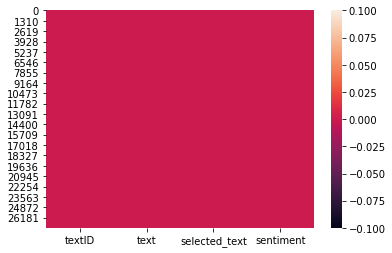

In [17]:
sns.heatmap(train.isnull())

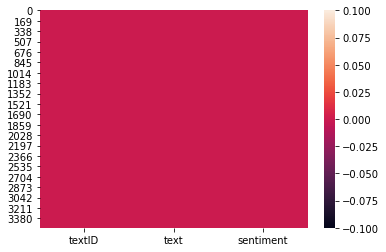

In [18]:
sns.heatmap(test.isnull())

In [19]:
train.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [15]:
test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [16]:
train.dropna(inplace=True)

In [20]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [43]:
temp=train.groupby('sentiment').count()['text'].reset_index().sort_values('text',ascending=False)
temp.style.background_gradient(cmap='Purples')

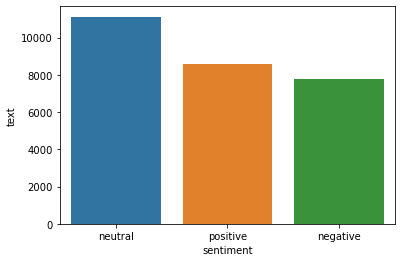

In [44]:
sns.barplot(data=temp,x='sentiment',y='text')

In [57]:
fig=go.Figure(go.Funnelarea(
        text=temp.sentiment,
        values=temp.text,
        title={'position':'top center',
              'text':'Funnel- Chart of Sentiment Distribution'}
        
        ))
fig.show()

In [66]:
def jaccard(str1,str2):
    a=set(str1.lower().split())
    b=set(str2.lower().split())
    c=a.intersection(b)
    return float(len(c))/(len(a)+len(b)-len(c))

In [67]:
jaccard(train.text[3],train.selected_text[3])

0.6

In [68]:
results_jaccard=[]
for i,j in train.iterrows():
    sentence1=j.text
    sentence2=j.selected_text
    score=jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,score])

In [69]:
results_jaccard[:10]

[[' I`d have responded, if I were going',
  'I`d have responded, if I were going',
  1.0],
 [' Sooo SAD I will miss you here in San Diego!!!', 'Sooo SAD', 0.2],
 ['my boss is bullying me...', 'bullying me', 0.16666666666666666],
 [' what interview! leave me alone', 'leave me alone', 0.6],
 [' Sons of ****, why couldn`t they put them on the releases we already bought',
  'Sons of ****,',
  0.21428571428571427],
 ['http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth',
  'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth',
  1.0],
 ['2am feedings for the baby are fun when he is all smiles and coos',
  'fun',
  0.07142857142857142],
 ['Soooo high', 'Soooo high', 1.0],
 [' Both of you', 'Both of you', 1.0],
 [' Journey!? Wow... u just became cooler.  hehe... (is that possible!?)',
  'Wow... u just became cooler.',
  0.5]]

In [74]:
jaccard=pd.DataFrame(results_jaccard,columns=['text','selected_text','jaccard_score'])
train=train.merge(jaccard,how='outer')
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  jaccard_score  
0  I`d have responded, if I were going   neutral       1.000000  
1                             Sooo SAD  negative       0.200000  
2                          bullying me  negative       0.166667  
3                       leave me alone  negative       0.600000  
4                        Sons of ****,  negative       0.214286

In [80]:
train['no_words_st']=train['selected_text'].apply(lambda x: len(str(x).split()))
train['no_words_txt']=train['text'].apply(lambda x: len(str(x).split()))
train['diff_in_words']=train['no_words_txt']-train['no_words_st']
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  jaccard_score  no_words_st  \
0  I`d have responded, if I were going   neutral       1.000000            7   
1                             Sooo SAD  negative       0.200000            2   
2                          bullying me  negative       0.166667            2   
3                       leave me alone  negative       0.600000            3   
4                        Sons of ****,  negative       0.214286            3   

   no_words_txt  diff_in_words  
0             7              0  
1            10              8  
2             5              3  
3             5              2  
4            14             11

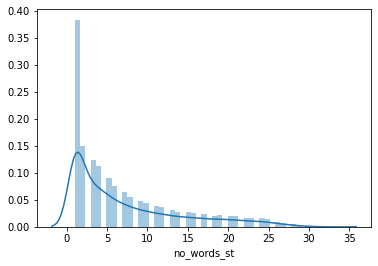

In [82]:
sns.distplot(train['no_words_st'])

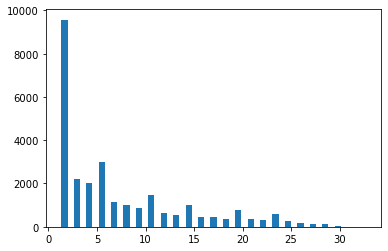

In [104]:
pl.hist(train['no_words_st'],bins=25,rwidth=0.5)
pl.show()

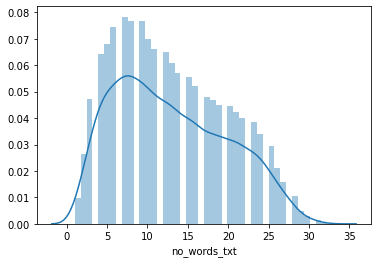

In [83]:
sns.distplot(train['no_words_txt'])

In [91]:
hist_data=[train['no_words_st'],train['no_words_txt']]
group_labels=['selected_text','text']

fig=ff.create_distplot(hist_data,group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of number of words')
fig.update_layout(autosize=False,
                 width=900,
                 height=700,
                 paper_bgcolor='LightSteelBlue')

fig.show()

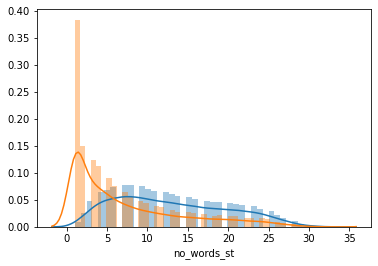

In [89]:
sns.distplot(train['no_words_txt'])
sns.distplot(train['no_words_st'])

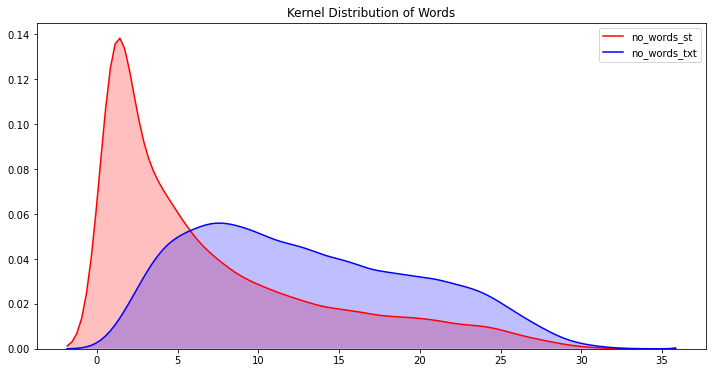

In [97]:
pl.figure(figsize=(12,6))
p1=sns.kdeplot(train['no_words_st'],shade=True,color='r').set_title('Kernel Distribution of Words')
p2=sns.kdeplot(train['no_words_txt'],shade=True,color='b')

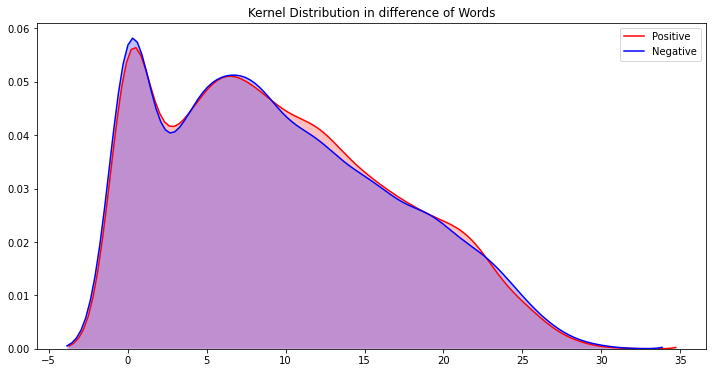

In [113]:
pl.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['diff_in_words'],shade=True,color='r').set_title('Kernel Distribution in difference of Words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['diff_in_words'],shade=True,color='b')
pl.legend(['Positive','Negative'])

In [105]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  jaccard_score  no_words_st  \
0  I`d have responded, if I were going   neutral       1.000000            7   
1                             Sooo SAD  negative       0.200000            2   
2                          bullying me  negative       0.166667            2   
3                       leave me alone  negative       0.600000            3   
4                        Sons of ****,  negative       0.214286            3   

   no_words_txt  diff_in_words  
0             7              0  
1            10              8  
2             5              3  
3             5              2  
4            14             11

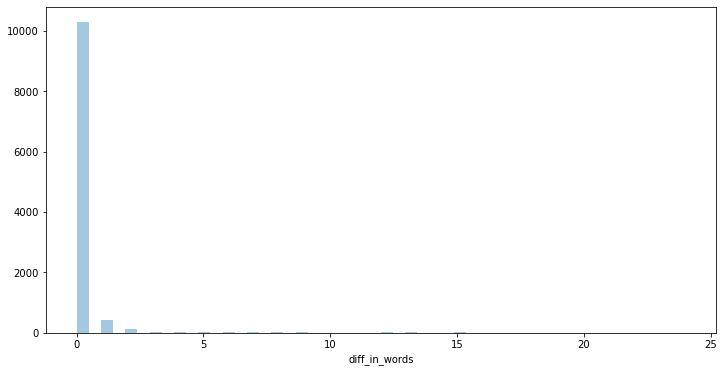

In [110]:
pl.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['diff_in_words'],kde=False)

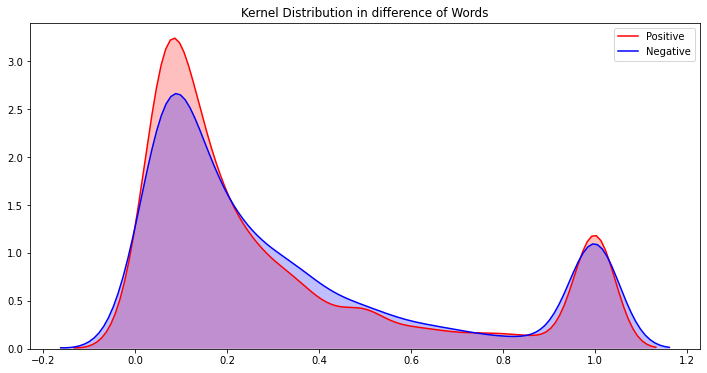

In [114]:
pl.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'],shade=True,color='r').set_title('Kernel Distribution in difference of Words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'],shade=True,color='b')
pl.legend(['Positive','Negative'])